In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Lyft Bay Wheels 
## Recommendations for Marketing Department 
### w205 Project 1 - Maria DiMedio

This report contains data and recommendations to answer two key questions of interest to our marketing department: 
1. What are our most common 'commuter' trips?
2. What offers can we use to increase our ridership?

Based on the findings illustrated in the following report, Lyft can target marketing efforts through our mobile app and offer deals which will increase ridership and in turn company profitability.

## Part 1: Commuter Riders
The first important focal point of this report is on commuter riders. Specifically, the most common commuter trips taken. Before proceeding with the analysis of trips recorded in the available data, an exploration of the data was required to understand which trips should be characterized as 'commuter'. After some analysis, the definition of a 'commuter' trip, as it will be referred to in this report, is any trip that is longer than two minutes, goes from one starting location to a different end location, and is made by a subscriber customer. The first few plots will describe this commuter customer base.

The breakdown of trips made customers who are 'subscribers', meaning they have a 30-day membership, vs. 'customers' who have a 3-day or 24 hour short term pass, can be seen in the plot below. From this barplot, we can see that the majority of trips are made by Subscribers, and we should therefore consider this when thinking about what the most valuable offers might be.

In [2]:
%%bigquery customers

select subscriber_type, count(*) as count_
from `bigquery-public-data`.san_francisco.bikeshare_trips
group by subscriber_type;

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.68rows/s]


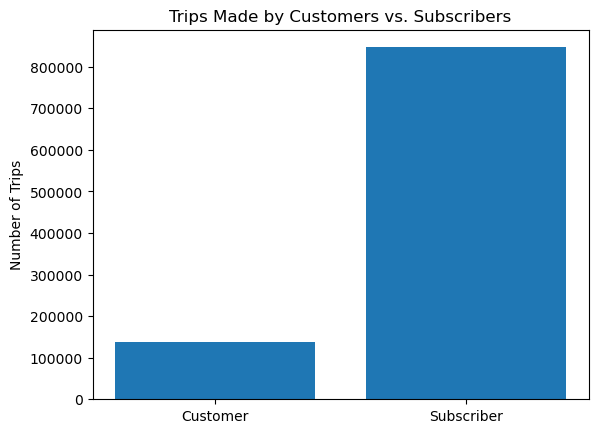

In [3]:
plt.bar(customers.subscriber_type,customers.count_)
plt.title('Trips Made by Customers vs. Subscribers')
plt.ylabel('Number of Trips')
pass

Next, it is also important to consider the direction of the trips. After some exploration, it is clear that the majority of trips are made directionally, from one starting location to a different end location. This can be seen in the plot below.

In [4]:
%%bigquery direction

select count(*) as num_trips, 
    case
        when start_station_id = end_station_id then 'circular trip'
        when start_station_id != end_station_id then 'destination trip' 
        else 'other'
    end 
    as trip_type
from `bigquery-public-data`.san_francisco.bikeshare_trips
group by trip_type;

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.54rows/s]


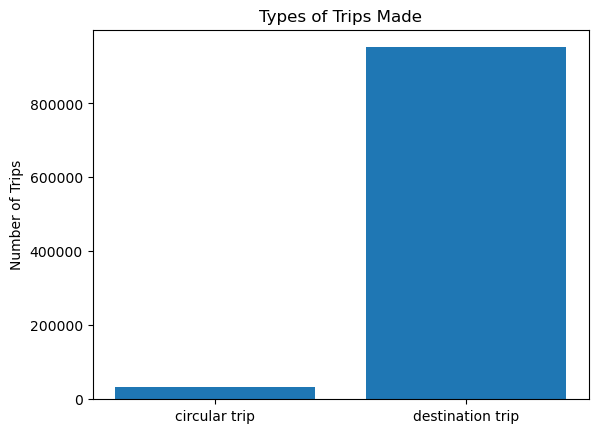

In [5]:
plt.bar(direction.trip_type,direction.num_trips)
plt.title('Types of Trips Made')
plt.ylabel('Number of Trips')
pass

Next, the duration of trips made provides additional insight into common commuter trips. When looking at the distribution of trip duration, most 'Customers' (short-term pass holders) took trips that lasted on average 1 hour, whereas Subscriber trips on average had a 10 minute duration. This tends to support the idea that Subscribers are more likely to be those commuting regularly, whereas Customers might be taking bike rides for pleasure, exercise, or errands. 

Additionally, a number of trips had durations of less than 2 minutes, which is likely an error in the data capture methods. For this reason, these trips were ommitted from consideration when analyzing commuter trips. 

The table below illustrates the distribution of trip durations for both Customers and Subscribers, where duration is represented in seconds.

In [6]:
%%bigquery duration

select subscriber_type, avg(duration_sec) as average_duration, max(duration_sec) as max_duration, min(duration_sec) as min_duration
from `bigquery-public-data`.san_francisco.bikeshare_trips
group by subscriber_type;

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.54rows/s]


In [7]:
duration

,subscriber_type,average_duration,max_duration,min_duration
0,Customer,3718.78516,17270400,60
1,Subscriber,582.76424,1852590,60


With this information, the number of total trips can be reduced to those likely to represent commuter trips, which go from one point to a different end location, are longer than 2 minutes, and have been made by Subscriber customers. The total number of trips is therefore reduced to 831383 to be considered for further exploration, as indicated below.

In [8]:
%%bigquery commuters

select count(*) as num_commuter_trips
from `bigquery-public-data`.san_francisco.bikeshare_trips
where duration_sec > 120 and start_station_id != end_station_id and subscriber_type = 'Subscriber';

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.32s/rows]


In [9]:
commuters

,num_commuter_trips
0,831383


Finally, the first main question of this report can be answered by analyzing the start-end location pairs and determining which routes are taken most by commuters. The 5 most popular commuter trips, as given by the available data, are listed below, along with the number of trips made. 

In [10]:
%%bigquery trips

select start_station_name, end_station_name, count(*) as trip_count
from (
    select * 
        from `bigquery-public-data`.san_francisco.bikeshare_trips
        where duration_sec > 120 and start_station_id != end_station_id and subscriber_type = 'Subscriber'
)
group by start_station_name, end_station_name
order by trip_count desc
limit 5;

Downloading: 100%|██████████| 5/5 [00:01<00:00,  4.37rows/s]


In [11]:
trips

,start_station_name,end_station_name,trip_count
0,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,8305
1,2nd at Townsend,Harry Bridges Plaza (Ferry Building),6931
2,Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),6635
3,Harry Bridges Plaza (Ferry Building),2nd at Townsend,6332
4,Embarcadero at Sansome,Steuart at Market,6200


## Part 2: Offer Recommendations

Having established what the 5 most common commuter trips are, next it is important to take a look at additional data on customer habits in order to make recommendations on what offers might be appealing and increase ridership through mobile app marketing. The following sections outline those data findings.

First, exploring the stations available, the following plot shows the stations that have the most bike docks and therefore the most potential for servicing customers.

In [12]:
%%bigquery docks

select station_id, name, dockcount
from `bigquery-public-data`.san_francisco.bikeshare_stations
order by dockcount desc
limit 5;

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.93rows/s]


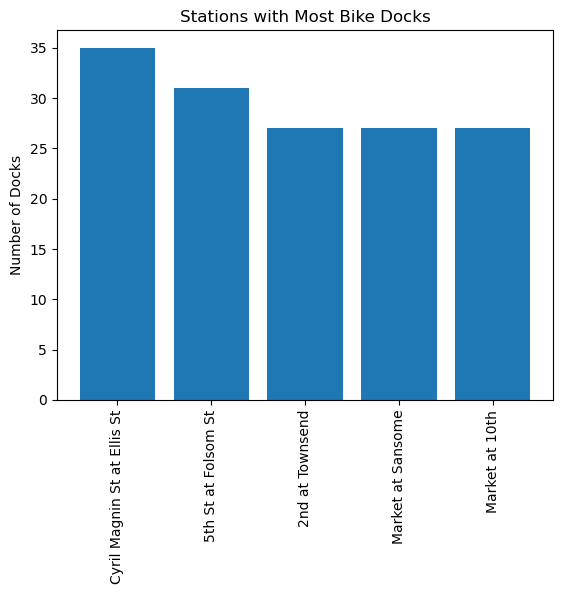

In [13]:
plt.bar(docks.name, docks.dockcount)
plt.xticks(rotation=90)
plt.title('Stations with Most Bike Docks')
plt.ylabel('Number of Docks')
pass

In order to have the most targeted offers, it is also helpful to understand where most of the customers live. The data provides the zip codes of those who use the bikes for each trip. Some data needed to be cleaned and accounted for when there was no information listed in the zipcode data field. An assessment of this data shows that the 5 zip codes with the most trips made by customers living there were 94107, 94105, 94133, 94103, and 94111. The distribution of trips made by customers from each zip code is shown in the plot below. 

In [14]:
%%bigquery zips 

select zip_code, count(zip_code) as count_trips
from `bigquery-public-data`.san_francisco.bikeshare_trips
where zip_code != 'nil'
group by zip_code
order by count_trips desc
limit 5;

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.93rows/s]


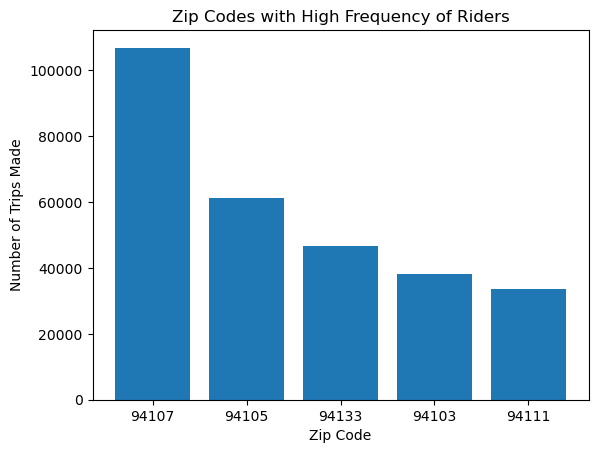

In [15]:
plt.bar(zips.zip_code, zips.count_trips)
plt.title('Zip Codes with High Frequency of Riders')
plt.ylabel('Number of Trips Made')
plt.xlabel('Zip Code')
pass

To guage customer activity, it is also helpful to understand the time of day when most trips are made. The following plot shows the distribution of trips made throughout the day, grouped by the hour. From this visualization, it is clear that the majority of trips are made during traditional commuting hours, with the maximum activity occuring at 8:00am and 5:00pm. This backs up the idea that the commuter population of customers should be a focus for marketing.

In [16]:
%%bigquery time

select extract(hour from start_date) as start_time_hour, count(*) as time_count
from `bigquery-public-data`.san_francisco.bikeshare_trips
group by start_time_hour
order by start_time_hour;

Downloading: 100%|██████████| 24/24 [00:01<00:00, 19.03rows/s]


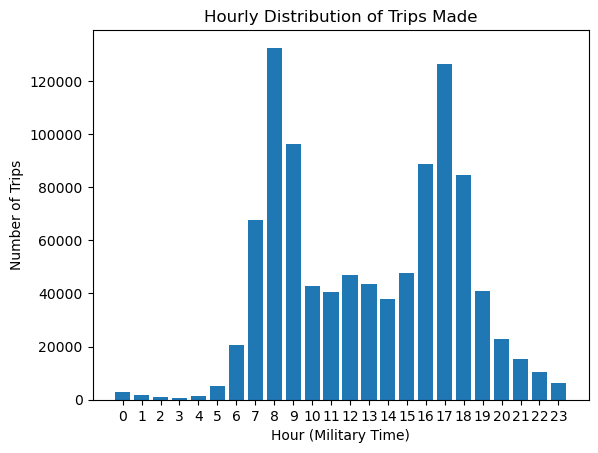

In [17]:
plt.bar(time.start_time_hour, time.time_count)
plt.title('Hourly Distribution of Trips Made')
plt.ylabel('Number of Trips')
plt.xlabel('Hour (Military Time)')
plt.xticks(ticks=time.start_time_hour)
pass

Similarly, the distribution of trips taken throughout the year is given by the plot below. From this, it can be seen that during the Winter, colder months, the number of trips taken decreases.

In [18]:
%%bigquery months

select extract(month from start_date) as month, count(*) as trips
from `bigquery-public-data`.san_francisco.bikeshare_trips
where duration_sec > 120 and start_station_id != end_station_id and subscriber_type = 'Subscriber'
group by month
order by month;

Downloading: 100%|██████████| 12/12 [00:01<00:00, 10.60rows/s]


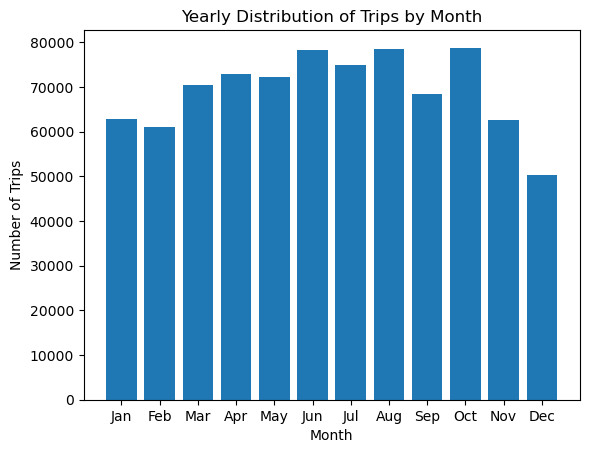

In [19]:
month_name = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
months['month_name'] = month_name

plt.bar(months.month_name,months.trips)
plt.title('Yearly Distribution of Trips by Month')
plt.ylabel('Number of Trips')
plt.xlabel('Month')
pass

Finally, the table below lists the 5 most commonly used commuter stations. This includes both trips made to and trips made from each location.

In [20]:
%%bigquery stations

select station, count(*) as trips from
  (select start_station_name as station from `bigquery-public-data`.san_francisco.bikeshare_trips
  where duration_sec > 120 and start_station_id != end_station_id and subscriber_type = 'Subscriber'
  union all
  select end_station_name as station from `bigquery-public-data`.san_francisco.bikeshare_trips
  where duration_sec > 120 and start_station_id != end_station_id and subscriber_type = 'Subscriber')
group by station 
order by trips desc
limit 5; 

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.97rows/s]


In [21]:
stations

,station,trips
0,San Francisco Caltrain (Townsend at 4th),154782
1,San Francisco Caltrain 2 (330 Townsend),109140
2,Harry Bridges Plaza (Ferry Building),74770
3,2nd at Townsend,73684
4,Temporary Transbay Terminal (Howard at Beale),70894


An interesting observation here is that although these stations are the most common for trips, they do not all have the highest number of docks available for bikes. Because of this, there are stations that are less frequently visited which have more docks that could be used for bikes. For example, Cyril Magnun St. at Ellis St. Station station has 35 docks, the most of any station, however it does not appear in the list above of stations with the most commuter trips made to or from them. It would likely be a good idea to draw traffic to this station, to increase ridership.

Considering the data insights listed above, the consumer trends in ridership indicate that the following offers would increase the number of riders using Lyft Bay Wheels.

1. **'Off-Hour and Seasonal Decreased Rates'**: As discovered by the data insights in this report, ridership is already very common and active during traditional commuter hours and during fair-weather months. Conversely, ridership decreases during late night hours and very early in the morning. Additionaly, we have found that in cold weather months like November and December, riders are using Lyft bikes less often. My first recommendation would be to provide discounts for subscribers who use bikes during these 'down' hours, and seasonal reductions in membership prices during the Winter. 

2. **'BART Targeted Regional Discounts'**: The Mobile App team should consider targeting discount codes for riders in geographical regions other than those most commonly using the Bay Wheels bikes. This data shows that the majority of trips are made by just a few zip codes comprising the Bay area. By partnering with the Bay Area Rapid Transit, Lyft should consider offering train commuters, who are entering the Bay area from another zip code, a decreased rate on memberships. This would target consumers who do not have a car in the city, but may still need to make a short journey from the train station to their place of employment. The marketing team and mobile app team should consider offering a discounted membership opportunity to BART pass holders for the last leg of their commute into the city.

3. **'Mobile App Discounts at Stations with Most Docks'**: Stations with many docks and bikes available should be a focus for marketing through the mobile app. I would recommend that we introduce an offer for riders who begin or end their trips at stations, such as Cyril Magnun St. at Ellis St. station. This station has the most docks available of any station, but does not get as much traffic as other stations. Therefore we should consider creating an offer of a reduced membership price for any riders who will begin or end their trips at these key high availability stations. This will draw in customers near these stations, and may also dilute the number of people using highest volume stations, generating more availability and in turn more overall riders across the Bay area. 

## Summary

In summary, in this report the top 5 commuter trips made in the Bay Area have been identified, and customer data was analyzed which engendered recommendations for new offers to increase riders through Lyft Bay Wheels' mobile app. In order to analyze the top 5 commuter trips, an analysis of the data was done to reduce the total number of trips to those that had clean data, were over 2 minutes long, went from one start location to a different end location, and were made by Subscribers. Additionally, 3 recommendations were made based on customer habits and data insights on bike stations available to customers. Those three recommendations for offers can be utilized by the development and marketing team to target customers who may increase their ridership for a reduced cost of membership, and were focused around identifying times, regions, and stations that were underutilized. These offers would incentivize customers to use bikes in off hours or colder weather, when they are commuting into the city by train, or when they are able to use stations with many docks but lower rider volume. By targeting offers in this way, Lyft can increase the overall ridership in the Bay Area.